In [1]:
import torch
from torch import nn, optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision.transforms.functional import to_tensor , to_pil_image
import os
from torchsummary import summary
import numpy as np
import PIL
import copy
import random
from PIL import Image
from scipy import ndimage as ndi ## New Pacakage for me
from skimage.segmentation import mark_boundaries
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
from torch.utils.data import Subset, DataLoader
from albumentations import HorizontalFlip , VerticalFlip , Compose , Resize

### **Exploring Dataset**

In [2]:
path2train = "/content/drive/MyDrive/Colab_Notebooks/Computer_Vision_02/04_Single_Object_Segmentation/Data /training_set"

In [3]:
imgList = []
anntList = []
for pp in os.listdir(path2train) :
  if "Annotation" not in pp :
    imgList.append(pp)

for at in os.listdir(path2train) :
  if "Annotation" in at :
    anntList.append(at)


In [4]:
print(f"Number of Images are {len(imgList)}")
print(f"Number of Annotation are {len(anntList)}")

Number of Images are 999
Number of Annotation are 999


###**Visualiztion Dataset**

In [5]:
def show_img_mask(img , mask) :
  if torch.is_tensor(img):
        img=to_pil_image(img)
        mask=to_pil_image(mask)
  img_mask = mark_boundaries(np.array(img),
                            np.array(mask),
                            color=(0, 1, 0),
                            outline_color=(0, 1, 0))
  plt.imshow(img_mask)


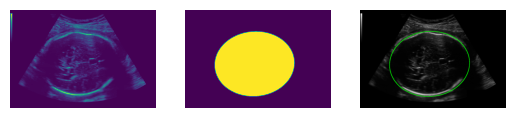

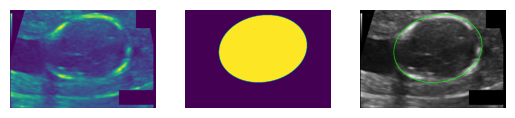

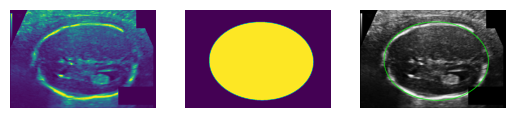

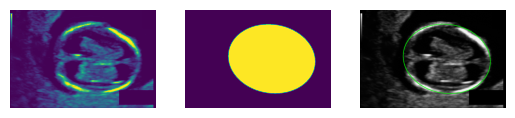

In [6]:
rndImgs = np.random.choice(imgList , 4)
rndImgs

for fn in rndImgs :
  path2img = os.path.join(path2train , fn)
  path2annt = path2img.replace(".png" , "_Annotation.png")
  img = Image.open(path2img)
  annt_edges = Image.open(path2annt)
  mask = ndi.binary_fill_holes(annt_edges)

  plt.figure()
  plt.subplot(1 , 3 , 1)
  plt.imshow(img)
  plt.axis("off")

  plt.subplot(1 , 3 , 2)
  plt.imshow(mask)
  plt.axis("off")

  plt.subplot(1 , 3, 3)
  show_img_mask(img , mask)
  plt.axis("off")

### Explanation of `from scipy import ndimage as ndi`

#### Introduction

The line `from scipy import ndimage as ndi` is a Python import statement commonly used in scientific computing. It brings in the `ndimage` module from the `scipy` library and assigns it the alias `ndi` for convenience.

#### Components

- **`scipy`**: A powerful scientific computing library in Python, building on NumPy. It provides interfaces for various tasks such as numerical integration, optimization, signal and image processing.

- **`ndimage`**: Stands for "n-dimensional image." It's a submodule within `scipy` that offers functions for multi-dimensional image processing, including tasks like image filtering, morphology, and measurements.


###**Data Augmentation**

In [7]:
h , w = 128 , 192
transform_train = Compose([Resize(h , w) ,
                          HorizontalFlip(p = 0.5) ,
                          VerticalFlip(p = 0.5)
                          ])

transform_val = Resize(h , w)

### **Preparing Dataset**

In [8]:
class FetalDataset(Dataset) :
  def __init__(self , path2data , transform = None):
    imgsList=[pp for pp in os.listdir(path2data) if "Annotation" not in pp]
    anntsList=[pp for pp in os.listdir(path2data) if "Annotation" in pp]
    self.path2imgs = [os.path.join(path2data, fn) for fn in imgsList]
    self.path2annts= [p2i.replace(".png", "_Annotation.png") for p2i in self.path2imgs]
    self.transform = transform

  def __len__(self) :
    return len(self.path2imgs)

  def __getitem__(self , idx) :
    path2img = self.path2imgs[idx]
    image = Image.open(path2img)

    path2annt = self.path2annts[idx]
    annt_edges = Image.open(path2annt)
    mask = ndi.binary_fill_holes(annt_edges)
    image = np.array(image)
    mask = mask.astype("uint8")

    if self.transform :
      augmented = self.transform(image = image , mask = mask)
      image = augmented["image"]
      mask = augmented["mask"]

    image = to_tensor(image)
    mask = 255*to_tensor(mask)
    return image , mask




In [9]:
fetal_ds1 = FetalDataset(path2train , transform = transform_train)
fetal_ds2 = FetalDataset(path2train , transform = transform_val)

In [10]:
print(len(fetal_ds1))
print(len(fetal_ds2))

999
999


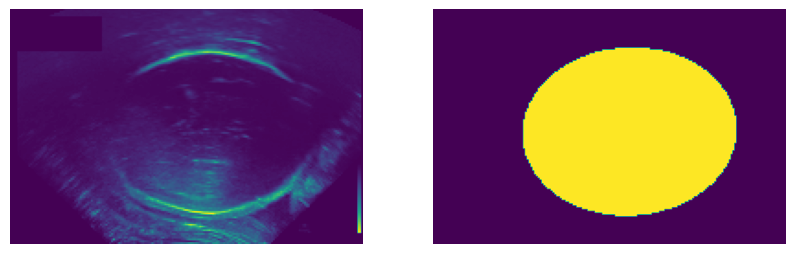

In [11]:
img , mask = fetal_ds1[random.choice(range(999))]
fig , (ax1 , ax2 ) = plt.subplots(figsize = (10 , 7) , nrows = 1 , ncols = 2)
ax1.imshow(img.permute(1 , 2 , 0));
ax1.axis("off")
ax2.imshow(mask.permute(1 , 2 , 0))
ax2.axis("off");

In [12]:
print(img.shape, img.type(),torch.max(img))
print(mask.shape, mask.type(),torch.max(mask))

torch.Size([1, 128, 192]) torch.FloatTensor tensor(0.9412)
torch.Size([1, 128, 192]) torch.FloatTensor tensor(1.)


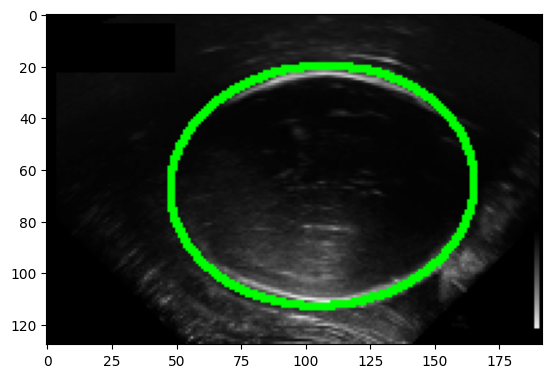

In [13]:
show_img_mask(img , mask)

In [14]:
sss = ShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
indices=range(len(fetal_ds1))

In [15]:
for train_index, val_index in sss.split(indices):
    print(len(train_index))
    print("-"*10)
    print(len(val_index))

799
----------
200


In [16]:
train_ds=Subset(fetal_ds1,train_index)
print(len(train_ds))

val_ds=Subset(fetal_ds2,val_index)
print(len(val_ds))

799
200


In [17]:
iage , msk = next(iter(train_ds))

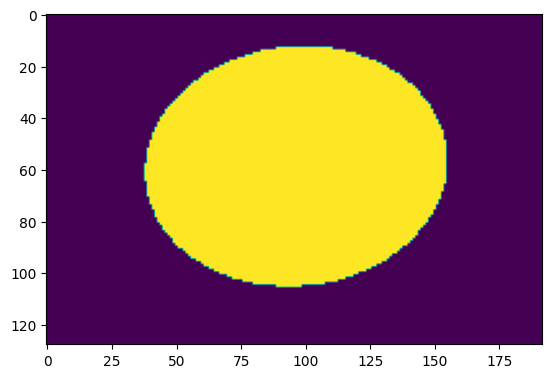

In [18]:
plt.imshow(msk.permute(1 , 2 , 0))

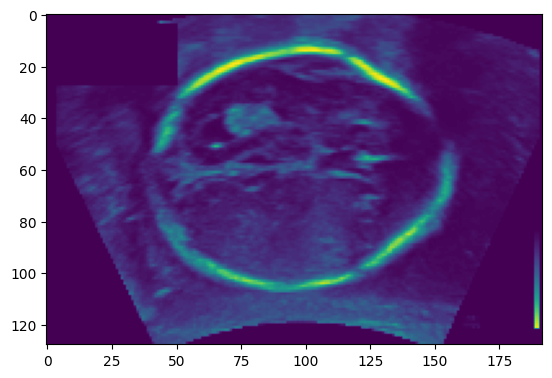

In [19]:
plt.imshow(iage.permute(1 , 2 , 0))

In [20]:
train_dl = DataLoader(train_ds, batch_size=8, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=16, shuffle=False)

In [21]:
for img_b, mask_b in train_dl:
    print(img_b.shape,img_b.dtype)
    print(mask_b.shape, mask_b.dtype)
    break

torch.Size([8, 1, 128, 192]) torch.float32
torch.Size([8, 1, 128, 192]) torch.float32


In [22]:
for img_b, mask_b in val_dl:
    print(img_b.shape,img_b.dtype)
    print(mask_b.shape, mask_b.dtype)
    break

torch.Size([16, 1, 128, 192]) torch.float32
torch.Size([16, 1, 128, 192]) torch.float32


### **Model Creation**

**The popular model architecture for segmentation tasks is the so-called encoder–decoder**

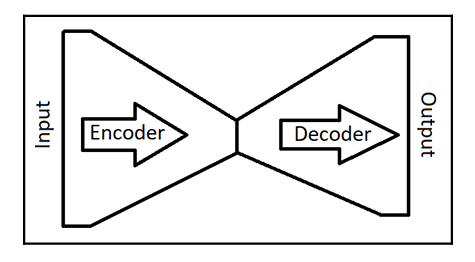

In [23]:
class SegNet(nn.Module):
    def __init__(self, params):
      super(SegNet, self).__init__()
      C_in, H_in, W_in=params["input_shape"]
      init_f=params["initial_filters"]
      num_outputs=params["num_outputs"]
      self.conv1 = nn.Conv2d(C_in, init_f, kernel_size=3,stride=1,padding=1)
      self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3,stride=1,padding=1)
      self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3,padding=1)
      self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size=3,padding=1)
      self.conv5 = nn.Conv2d(8*init_f, 16*init_f, kernel_size=3,padding=1)
      self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
      self.conv_up1 = nn.Conv2d(16*init_f, 8*init_f, kernel_size=3,padding=1)
      self.conv_up2 = nn.Conv2d(8*init_f, 4*init_f, kernel_size=3,padding=1)
      self.conv_up3 = nn.Conv2d(4*init_f, 2*init_f, kernel_size=3,padding=1)
      self.conv_up4 = nn.Conv2d(2*init_f, init_f, kernel_size=3,padding=1)
      self.conv_out = nn.Conv2d(init_f, num_outputs , kernel_size=3,padding=1)

    def forward(self, x):
      x = F.relu(self.conv1(x))
      x = F.max_pool2d(x, 2, 2)
      x = F.relu(self.conv2(x))
      x = F.max_pool2d(x, 2, 2)
      x = F.relu(self.conv3(x))
      x = F.max_pool2d(x, 2, 2)
      x = F.relu(self.conv4(x))
      x = F.max_pool2d(x, 2, 2)
      x = F.relu(self.conv5(x))
      x=self.upsample(x)
      x = F.relu(self.conv_up1(x))
      x=self.upsample(x)
      x = F.relu(self.conv_up2(x))
      x=self.upsample(x)
      x = F.relu(self.conv_up3(x))
      x=self.upsample(x)
      x = F.relu(self.conv_up4(x))
      x = self.conv_out(x)
      return x

In [24]:
params_model={
        "input_shape": (1,h,w),
        "initial_filters": 16,
        "num_outputs": 1,
            }
model = SegNet(params_model)

In [25]:
if torch.cuda.is_available():
  device = "cuda"

else :
  device = "cpu"

In [26]:
model = model.to(device)

In [27]:
print(model)

SegNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (upsample): Upsample(scale_factor=2.0, mode='bilinear')
  (conv_up1): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_up2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_up3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_up4): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_out): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [28]:
summary(model, input_size=(1, h, w))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 192]             160
            Conv2d-2           [-1, 32, 64, 96]           4,640
            Conv2d-3           [-1, 64, 32, 48]          18,496
            Conv2d-4          [-1, 128, 16, 24]          73,856
            Conv2d-5           [-1, 256, 8, 12]         295,168
          Upsample-6          [-1, 256, 16, 24]               0
            Conv2d-7          [-1, 128, 16, 24]         295,040
          Upsample-8          [-1, 128, 32, 48]               0
            Conv2d-9           [-1, 64, 32, 48]          73,792
         Upsample-10           [-1, 64, 64, 96]               0
           Conv2d-11           [-1, 32, 64, 96]          18,464
         Upsample-12         [-1, 32, 128, 192]               0
           Conv2d-13         [-1, 16, 128, 192]           4,624
           Conv2d-14          [-1, 1, 1

###**Loss Function**

The BCE loss function compares each pixel of the prediction with that
of the ground truth; however, we can combine multiple criteria to improve the overall
performance of segmentation tasks. A popular technique is to combine the dice metric with
the BCE loss. The dice metric is commonly used to test the performance of segmentation
algorithms by calculating the amount of overlap between the ground truth and the
prediction

In [29]:
def dice_loss(pred , target , smooth = 1e-5) :
  intersection = (pred * target).sum(dim = (2 , 3))
  union = pred.sum(dim = (2 , 3)) + target.sum(dim = (2 , 3))
  dice = 2.0 * (intersection + smooth) / (union + smooth)
  loss = 1.0 - dice
  return loss.sum() , dice.sum()

In [30]:
def loss_func(pred , target) :
  bce = F.binary_cross_entropy_with_logits(pred , target.float() , reduction = "sum")
  pred = torch.sigmoid(pred)
  dlv, _ = dice_loss(pred , target)
  loss = bce + dlv
  return loss

In [31]:

for img_v,mask_v in val_dl:
    mask_v= mask_v[8:]
    break

for img_t,mask_t in train_dl:
    break



print(dice_loss(mask_v,mask_v))
loss_func(mask_v,torch.zeros_like(mask_v))

(tensor(0.), tensor(8.))


tensor(173975.0156)

In [32]:
def loss_batch(loss_func , output , target , opt = None):
  loss = loss_func(output , target)
  with torch.no_grad() :
    pred = torch.sigmoid(output)
    _ , metric_b = dice_loss(pred , target)

  if opt is not None :
    opt.zero_grad()
    loss.backward()
    opt.step()
  return loss.item() , metric_b

In [33]:
opt = optim.Adam(model.parameters() , lr = 3e-4)

In [34]:
lr_scheduler = ReduceLROnPlateau(opt , mode = "min" , factor = 0.5 , patience = 20 , verbose = 1)

###**Training the Model**

In [35]:
def loss_epoch(model,loss_func,dataset_dl,sanity_check=False,opt=None):
  running_loss=0.0
  running_metric=0.0
  len_data=len(dataset_dl.dataset)
  for xb, yb in dataset_dl:
    xb=xb.to(device)
    yb=yb.to(device)
    output=model(xb)
    loss_b, metric_b=loss_batch(loss_func, output, yb, opt)
    running_loss += loss_b
    if metric_b is not None:
      running_metric+=metric_b
    if sanity_check is True:
      break

  loss=running_loss/float(len_data)
  metric=running_metric/float(len_data)
  return loss, metric

**Note:** **Sanity check** in this context refers to a quick verification to ensure that a particular part of the code is working as expected.
In the provided function loss_epoch, if sanity_check is set to True, the function will only run through one batch of the dataset (dataset_dl) instead of the entire dataset. This can be useful during development or debugging to quickly check if the loss calculation and optimization steps are functioning correctly without having to process the entire dataset. Once you confirm the code is running as expected for a small subset, you can then set sanity_check to False for the full training or evaluation run.

In [36]:
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

In [37]:
def train_val(model, params):
  num_epochs=params["num_epochs"]
  loss_func=params["loss_func"]
  opt=params["optimizer"]
  train_dl=params["train_dl"]
  val_dl=params["val_dl"]
  sanity_check=params["sanity_check"]
  lr_scheduler=params["lr_scheduler"]
  path2weights=params["path2weights"]

  loss_history={
    "train": [],
    "val": []}
  metric_history={
    "train": [],
    "val": []}

  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss=float('inf')

  for epoch in range(num_epochs):
    current_lr=get_lr(opt)
    print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs - 1, current_lr))
    model.train()
    train_loss, train_metric=loss_epoch(model,loss_func,train_dl,sanity_check,opt)
    loss_history["train"].append(train_loss)
    metric_history["train"].append(train_metric)

    model.eval()
    with torch.no_grad():
      val_loss, val_metric=loss_epoch(model,loss_func,val_dl,sanity_check)

    loss_history["val"].append(val_loss)
    metric_history["val"].append(val_metric)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())

      torch.save(model.state_dict(), path2weights)
      print("Copied best model weights!")

    lr_scheduler.step(val_loss)
    if current_lr != get_lr(opt):
      print("Loading best model weights!")
      model.load_state_dict(best_model_wts)

    print("train loss: %.6f, dice: %.2f" %(train_loss,100*train_metric))
    print("val loss: %.6f, dice: %.2f" %(val_loss,100*val_metric))
    print("-"*10)

  model.load_state_dict(best_model_wts)
  return model, loss_history, metric_history

In [38]:
path2models= "/content/drive/MyDrive/Colab_Notebooks/Computer_Vision_02/04_Single_Object_Segmentation/Models"
if not os.path.exists(path2models):
        os.mkdir(path2models)

params_train={
    "num_epochs": 100,
    "optimizer": opt,
    "loss_func": loss_func,
    "train_dl": train_dl,
    "val_dl": val_dl,
    "sanity_check": False,
    "lr_scheduler": lr_scheduler,
    "path2weights": path2models+"weights.pt",
}

model,loss_hist,metric_hist=train_val(model,params_train)

Epoch 0/99, current lr=0.0003
Copied best model weights!
train loss: 11738.946999, dice: 42.33
val loss: 8093.498359, dice: 55.25
----------
Epoch 1/99, current lr=0.0003
Copied best model weights!
train loss: 6757.348580, dice: 67.34
val loss: 5680.072578, dice: 75.87
----------
Epoch 2/99, current lr=0.0003
Copied best model weights!
train loss: 4986.429587, dice: 76.04
val loss: 4170.459092, dice: 81.12
----------
Epoch 3/99, current lr=0.0003
Copied best model weights!
train loss: 4113.680971, dice: 79.55
val loss: 3753.520977, dice: 81.48
----------
Epoch 4/99, current lr=0.0003
Copied best model weights!
train loss: 3590.592848, dice: 81.80
val loss: 3465.967852, dice: 83.41
----------
Epoch 5/99, current lr=0.0003
Copied best model weights!
train loss: 3220.880050, dice: 83.49
val loss: 2713.345488, dice: 86.42
----------
Epoch 6/99, current lr=0.0003
Copied best model weights!
train loss: 2654.409699, dice: 86.41
val loss: 2623.084316, dice: 88.36
----------
Epoch 7/99, current

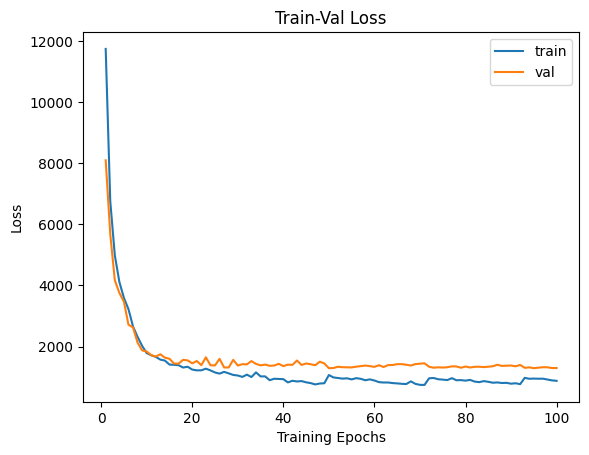

In [40]:
num_epochs=params_train["num_epochs"]

plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

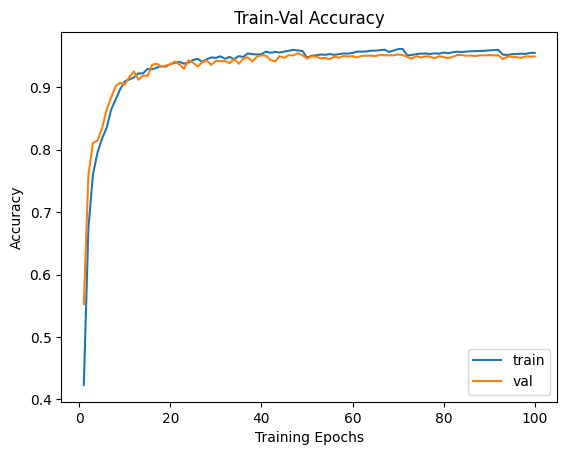

In [47]:
plt.title("Train-Val Accuracy")
plt.plot(range(1,num_epochs+1),torch.tensor(metric_hist["train"]).cpu(),label="train")
plt.plot(range(1,num_epochs+1),torch.tensor(metric_hist["val"]).cpu(),label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()